# Notebook for Kaggle competition "Titanic"
Author: Dirk Ulbricht, dirk@neuefische.de

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model

%matplotlib inline
plt.style.use('seaborn')


### Variable description (from Kaggle)

| Variable | Definition                                 | Key                                            | Type        |
|:----------|:--------------------------------------------|:------------------------------------------------|-------------|
| Survived | Survival                                   | 0 = No, 1 = Yes                                | nominal     |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      | ordinal     |
| Sex      | Sex                                        |                                                | dichotomous |
| Age      | Age in years                               |                                                | ratio       |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                | ratio       |
| Parch    | # of parents / children aboard the Titanic |                                                |             |
| Ticket   | Ticket number                              |                                                | nominal     |
| Fare     | Passenger fare                             |                                                | ratio       |
| Cabin    | Cabin number                               |                                                | nominal     |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton | nominal     |


In [162]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [163]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [169]:
X = pd.concat([train,test],sort=True)


### Type of data and missings

In [175]:
# Getting a first idea of the data
print('Number of rows and columns of train: ',train.shape,
      '\nNumber of rows and columns of test:  ',test.shape)
train.head()

Number of rows and columns of train:  (891, 12) 
Number of rows and columns of test:   (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [176]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 107.4+ KB


In [178]:
missing = pd.DataFrame(X.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/X.shape[0]*100,1)
missing[missing.Number!=0]


,Number,Percentage
Age,263,20.1
Cabin,1014,77.5
Embarked,2,0.2
Fare,1,0.1
Survived,418,31.9


Of the 12 variables 3 have missing values. 
- **Embarked** has only 2 instances or .2 percent missing values 
- **Cabin** has no values for 77.5 percent of instances
- **Age** is not known in 20.1 percent of all cases
- **Fare** is missing in one case

## Getting some basic statistics

In [179]:
X.describe().round(2)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.00,1308.00,1309.00,1309.00,1309.00,1309.00,891.00
mean,29.88,33.30,0.39,655.00,2.29,0.50,0.38
std,14.41,51.76,0.87,378.02,0.84,1.04,0.49
min,0.17,0.00,0.00,1.00,1.00,0.00,0.00
25%,21.00,7.90,0.00,328.00,2.00,0.00,0.00
50%,28.00,14.45,0.00,655.00,3.00,0.00,0.00
75%,39.00,31.28,0.00,982.00,3.00,1.00,1.00
max,80.00,512.33,9.00,1309.00,3.00,8.00,1.00


### Correlation analyis

$r_{x,y} = \frac{\Sigma_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\Sigma_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\Sigma_{i=1}^{n}(y_i-\bar{y})^2}}=\frac{Cov(x,y)}{Std(x)\times Std(y)}$


In [180]:
continuous_var = list(X.select_dtypes(
                        ['int64','float64','bool']).columns.values)
continuous_var.remove('PassengerId')
categorical_var=['Sex','Embarked']

(1309, 11)

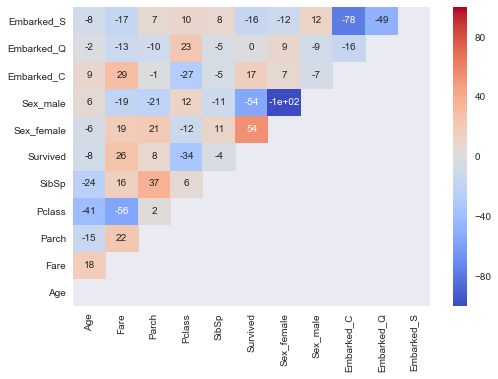

In [181]:
X_dum=pd.get_dummies(X[continuous_var+categorical_var].copy())
mask = np.triu(X_dum.corr())
ax = sns.heatmap(round(X_dum.corr()*100,0),annot=True,mask=mask,cmap='coolwarm')
ax.set_ylim((0,11))
X_dum.shape

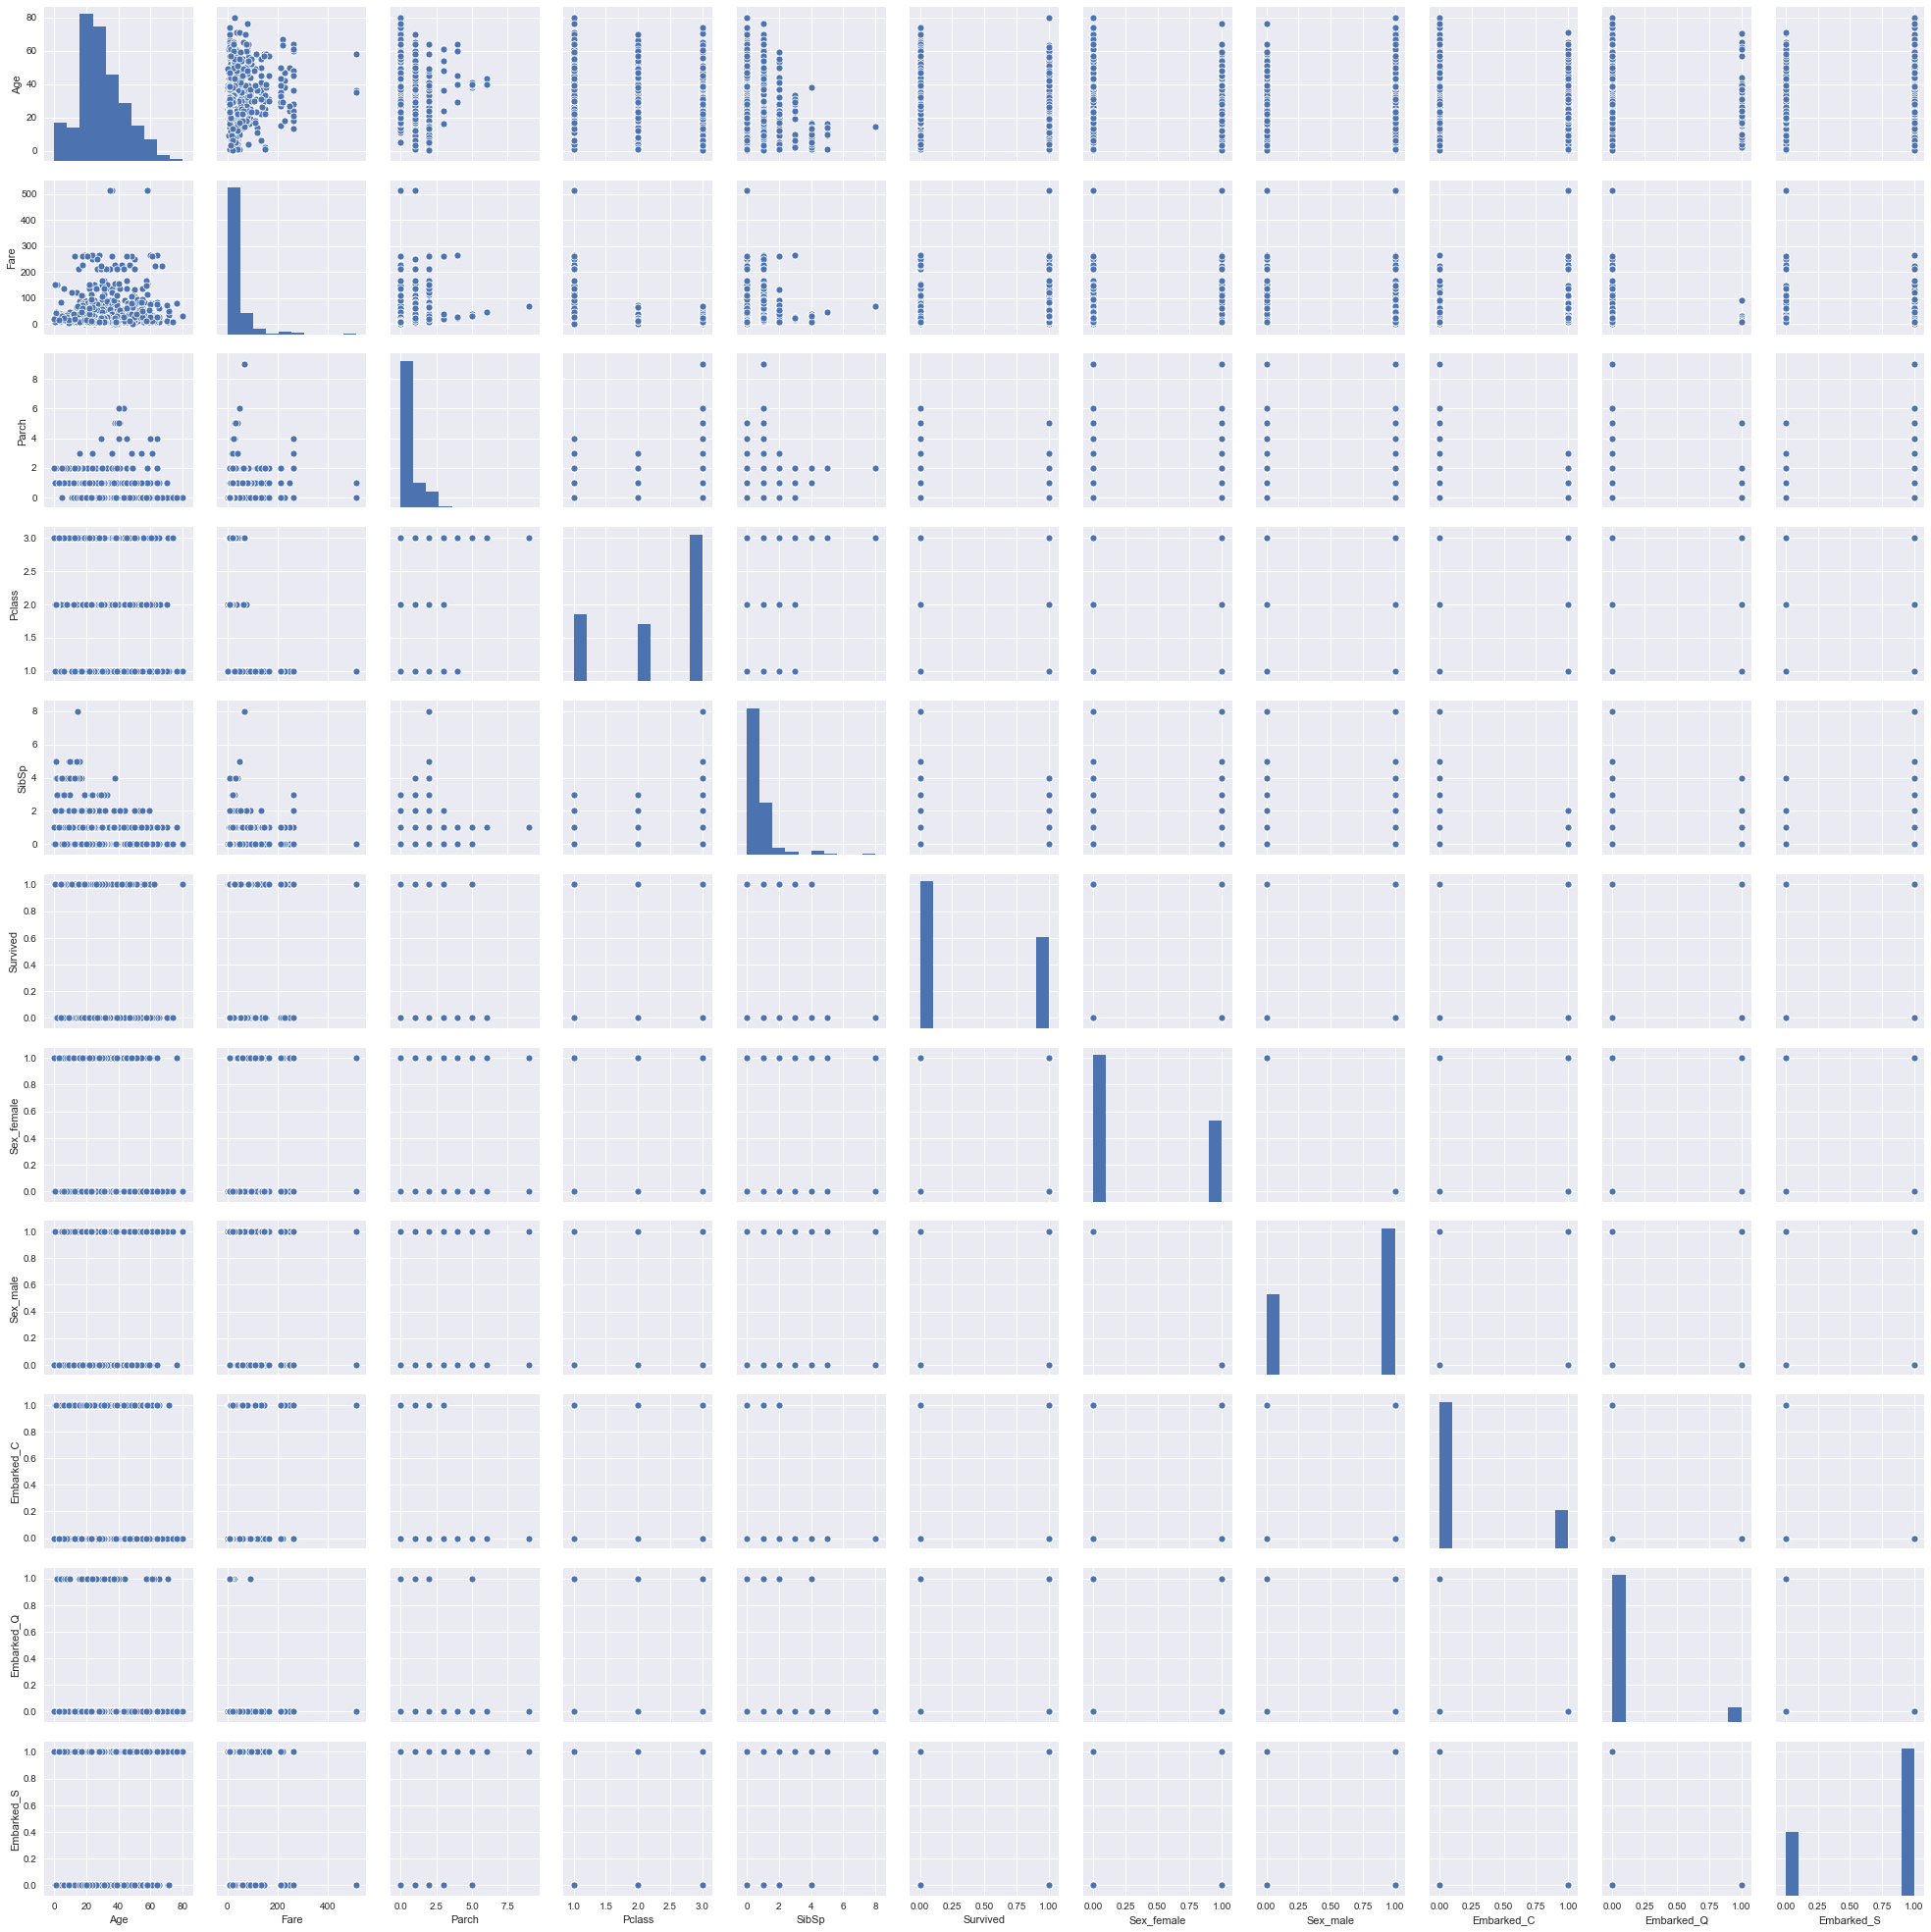

In [184]:
sns.pairplot(X_dum)

### Histograms 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x197541B0>,
      dtype=object)

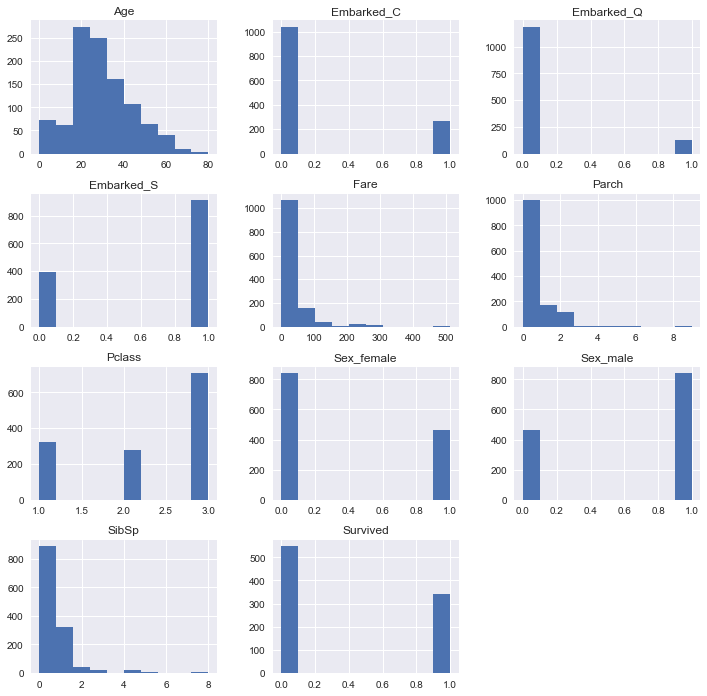

In [185]:
X_dum.hist(figsize=(12,12))

# Looking at variable individually creating new features

### Survivors and casualties

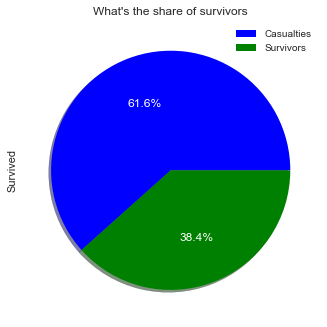

In [186]:
Fig_age_survivial = pd.value_counts(train.Survived).plot.pie(autopct='%1.1f%%', shadow=True,colors=['blue','green'],
                                  textprops=dict(color="w",size='12'))
plt.title('What\'s the share of survivors')
plt.legend(['Casualties','Survivors'])
#plt.savefig('Survived_pie.png')

### Siblings-Spouses (SibSp) and Parents-Children (Parch)
Let's see if creating a new feature **_relatives_** is helpful for the analysis


Percentages of passengers having 0 to 10 relatives

    Siblings & Spouse  Parents & children  Relatives
0                68.1                76.5       60.4
1                24.4                13.0       18.0
2                 3.2                 8.6       12.1
3                 1.5                 0.6        3.3
4                 1.7                 0.5        1.7
5                 0.5                 0.5        1.9
6                 NaN                 0.2        1.2
7                 NaN                 NaN        0.6
8                 0.7                 NaN        NaN
9                 NaN                 0.2        NaN
10                NaN                 NaN        0.8


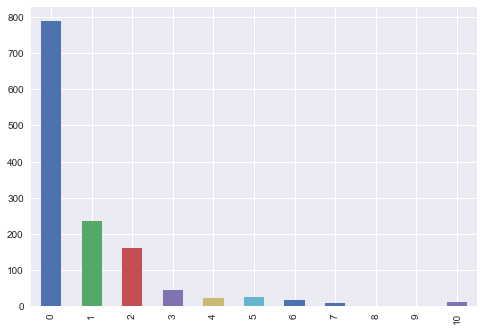

In [191]:
X['relatives'] = X.SibSp + X.Parch

Relatives = pd.DataFrame(X.SibSp.value_counts()).merge(
    pd.DataFrame(X.Parch.value_counts())
               ,left_index=True
               ,right_index=True
               ,how='outer'
              ).merge(
    pd.DataFrame(X.relatives.value_counts())
                ,left_index=True
                 ,right_index=True
                 ,how='outer'
)
Relatives.columns = ['Siblings & Spouse','Parents & children','Relatives']
print('\nPercentages of passengers having 0 to 10 relatives\n')
print(round(Relatives/X.shape[0]*100,1))

Relatives.Relatives.plot(kind='bar')

## Name

Some of the passengers have a certain societal rank that can be identified by the title given in the passenger list. 
1. From [wikipedia](https://en.wikipedia.org/wiki/Master_(form_of_address)) "**Master** was used in England for men of some rank, especially "free masters" of a trade guild and by any manual worker or servant employee addressing his employer (his master), but also generally by those lower in status to gentlemen, priests, or scholars."
2. There are some Drs., Reverends, Col., Majors. and a Capt.
3. Some of the women were wed (Mrs, Mme, some unwed (Miss, Ms and Mlle)

In [194]:
X.Name[:20]

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [197]:
title = X.Name.map(lambda x: x.split(",")[1]
              ).map(lambda x: x.split(".")[0].strip()
                   )
title_test = test.Name.map(lambda x: x.split(",")[1]
              ).map(lambda x: x.split(".")[0].strip()
                   )
print('\nTypes and frequencies of titles\n')
title.value_counts()#.head(100)



Types and frequencies of titles



Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Ms                2
Major             2
Don               1
Sir               1
Jonkheer          1
Dona              1
the Countess      1
Lady              1
Capt              1
Mme               1
Name: Name, dtype: int64

##### Creating new column title_honor

In [198]:
# first, drop mrs, mr, miss and mme
title_honor = list(title.unique())
title_drop = ['Mrs', 'Mr', 'Miss', 'Mme','Mlle','Don','Dona']
for a in title_drop: title_honor.remove(a)
X['title_honor']=[a in title_honor for a in title]
test['title_honor']=[a in title_honor for a in title_test]

##### Creating new column unmarried_women

In [199]:
X[X.Sex=='female'].Name.map(lambda x: x.split(",")[1]
              ).map(lambda x: x.split(".")[0]
                   ).value_counts()#.

 Miss            260
 Mrs             197
 Ms                2
 Mlle              2
 the Countess      1
 Dr                1
 Lady              1
 Mme               1
 Dona              1
Name: Name, dtype: int64

All women that do not have the title Mrs or Mme will be labeled as unmarried.

In [201]:
X['unmarried_woman']=X.Name.map(
    lambda x:  1-bool(re.search('Mrs.|Mlle.',x)))

### Ticket and Fare
- Which passengers had the same ticket number?
- Do we have to adjust the fare for the number of people how shared the same ticket number?
- Does the ticket number give any hint to where the cabins of the passengers were?

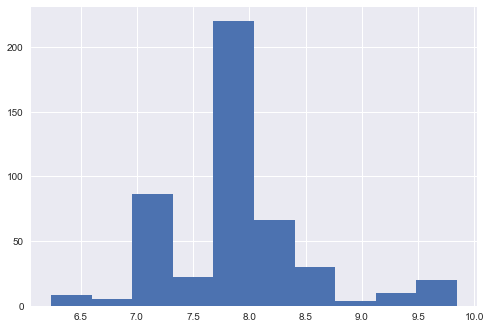

In [202]:
X.sort_values(by=['Ticket'],ascending=False)
X.Fare[(X.Fare>5) & (X.Fare<10)].hist()

Text(0.5, 1.0, '3rd Class')

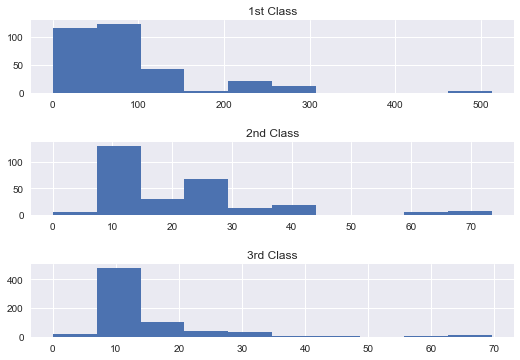

In [203]:
fig, axes = plt.subplots(3,1)
fig.tight_layout(pad=3.0)
X.Fare[X.Pclass==1].hist(ax=axes[0])
axes[0].set_title('1st Class')
X.Fare[X.Pclass==2].hist(ax=axes[1])
axes[1].set_title('2nd Class')
X.Fare[X.Pclass==3].hist(ax=axes[2])
axes[2].set_title('3rd Class')

In [206]:
X.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [207]:
ticket_prefix = X.Ticket.map(lambda x: x.split()).map(lambda x: x[0] if len(x)>1   else "")
ticket_number = X.Ticket.map(lambda x: x.split()).map(lambda x: x[0] if len(x)==1   else x[1])


### Embarkation

In [208]:
embarked_survival=round(X.groupby(['Embarked','Survived'])['PassengerId'].agg('count')\
                    /X.groupby('Embarked').count()['PassengerId']*100,2)
embarked_survival

Embarked  Survived
C         0.0         27.78
          1.0         34.44
Q         0.0         38.21
          1.0         24.39
S         0.0         46.72
          1.0         23.74
Name: PassengerId, dtype: float64

Text(0.5, 1.0, 'Embarking in Cherbour is lifesaving')

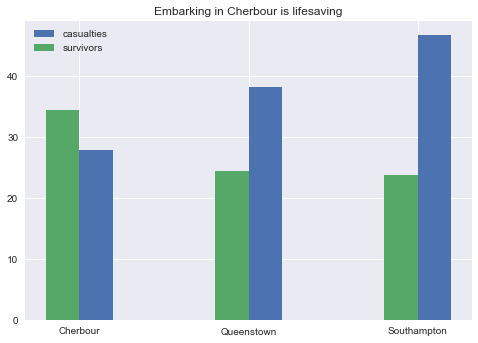

In [209]:
tt = embarked_survival.reset_index().set_index('Embarked')
survived = tt[tt['Survived']==0].PassengerId
dead = tt[tt['Survived']==1].PassengerId
plt.bar([1.2,2.2,3.2],survived, width=0.2)
plt.bar([1,2,3],dead,width=0.2)
plt.xticks([1.1,2.1,3.1], ['Cherbour', 'Queenstown', 'Southampton'])
plt.legend(['casualties','survivors'])
plt.title('Embarking in Cherbour is lifesaving')

### Sex matters for survival

In [211]:
train_cat = train.select_dtypes(include='object').copy()
train_cat#value_counts()
[female_n,male_n]=[train.loc[train['Sex']=='female','PassengerId'].count(),train.loc[train['Sex']=='male','PassengerId'].count()]
sex_crosstab=round(pd.crosstab(train.Survived,train.Sex)/[female_n,male_n]*100,1)
print(sex_crosstab)



Sex       female  male
Survived              
0           25.8  81.1
1           74.2  18.9


### Passenger Class

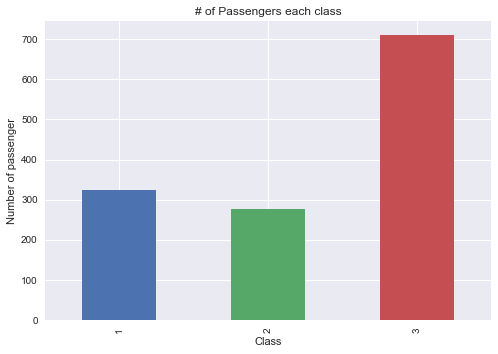

In [215]:

pd.value_counts(X.Pclass).sort_index().plot.bar(title="# of Passengers each class")

plt.ylabel('Number of passenger')
plt.xlabel('Class')
plt.savefig('figures/Pclass.png')

### Age of passengers

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64


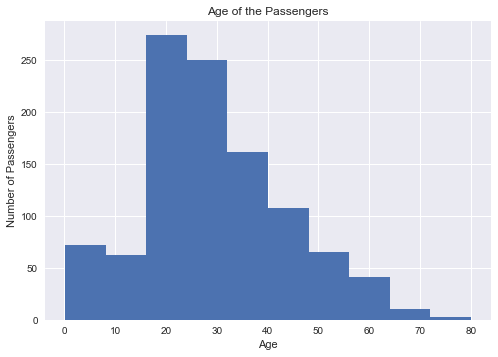

In [216]:
print(X.Age.describe())
X.Age.hist()
plt.title('Age of the Passengers')
plt.ylabel('Number of Passengers')
plt.xlabel('Age')
plt.savefig('ageHist.png')


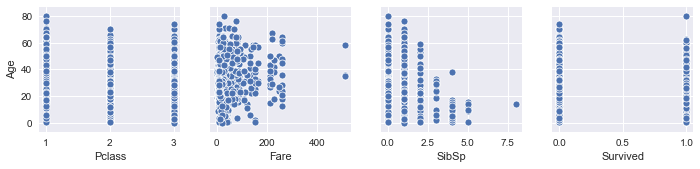

In [217]:
fig_all_about_age = sns.pairplot(X_dum,y_vars=["Age"],x_vars=['Pclass','Fare','SibSp','Survived'])

In [159]:
class_survival=round(train.groupby(['Pclass','Survived']).count()\
                     ['PassengerId']/train.groupby('Pclass').count()['PassengerId']*100,2)


In [160]:
class_survival=round(train.groupby(['Pclass','Survived'])['PassengerId'].agg('count')\
                    /train.groupby('Pclass').count()['PassengerId']*100,2)
class_survival

Pclass  Survived
1       0           37.04
        1           62.96
2       0           52.72
        1           47.28
3       0           75.76
        1           24.24
Name: PassengerId, dtype: float64

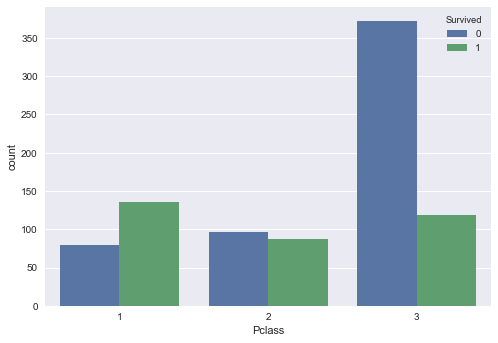

In [231]:
fig_age_class_survive = train.groupby(['Pclass','Survived'])#.plot(kind='bar')
sns.countplot(x='Pclass',data=train, hue='Survived')
fig_age_class_survive


count    1308.00
mean       33.30
std        51.76
min         0.00
25%         7.90
50%        14.45
75%        31.28
max       512.33
Name: Fare, dtype: float64

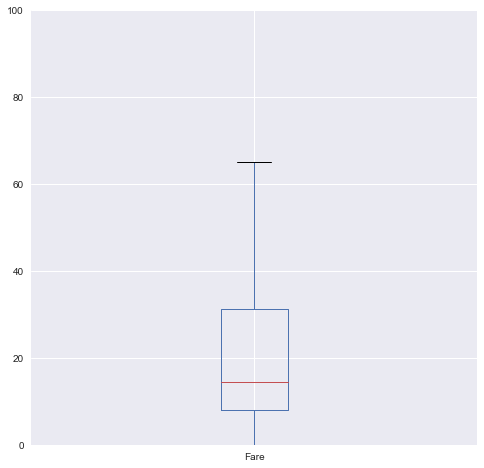

In [232]:
X.Fare.plot(kind='box',figsize=(8,8),ylim=(0,100))
X.Fare.describe().round(2)

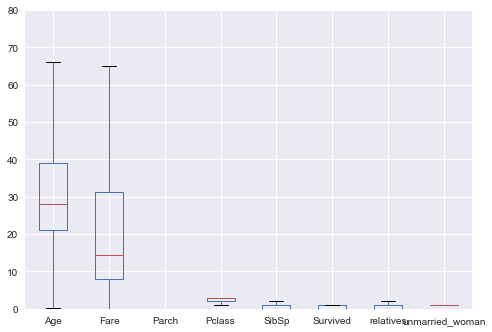

In [234]:
#needs to be plotted individually and moved to top
X.iloc[:,X.columns!='PassengerId'].plot(kind='box',ylim=(0,80))#,figsize=(8,6))

In [236]:
X_dum.corr().round(2)

,Age,Fare,Parch,Pclass,SibSp,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Age,1.00,0.18,-0.15,-0.41,-0.24,-0.08,-0.06,0.06,0.09,-0.02,-0.08
Fare,0.18,1.00,0.22,-0.56,0.16,0.26,0.19,-0.19,0.29,-0.13,-0.17
Parch,-0.15,0.22,1.00,0.02,0.37,0.08,0.21,-0.21,-0.01,-0.10,0.07
Pclass,-0.41,-0.56,0.02,1.00,0.06,-0.34,-0.12,0.12,-0.27,0.23,0.10
SibSp,-0.24,0.16,0.37,0.06,1.00,-0.04,0.11,-0.11,-0.05,-0.05,0.08
Survived,-0.08,0.26,0.08,-0.34,-0.04,1.00,0.54,-0.54,0.17,0.00,-0.16
Sex_female,-0.06,0.19,0.21,-0.12,0.11,0.54,1.00,-1.00,0.07,0.09,-0.12
Sex_male,0.06,-0.19,-0.21,0.12,-0.11,-0.54,-1.00,1.00,-0.07,-0.09,0.12
Embarked_C,0.09,0.29,-0.01,-0.27,-0.05,0.17,0.07,-0.07,1.00,-0.16,-0.78
Embarked_Q,-0.02,-0.13,-0.10,0.23,-0.05,0.00,0.09,-0.09,-0.16,1.00,-0.49


Text(0.5, 1.0, 'The class makes a difference')

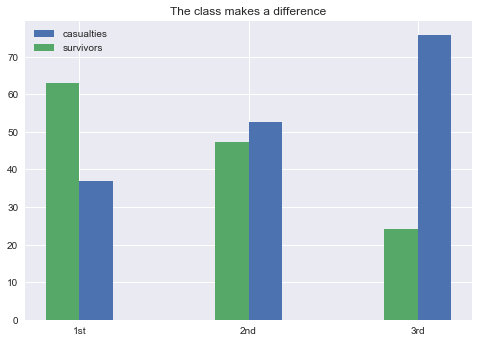

In [161]:
tt = class_survival.reset_index().set_index('Pclass')
survived = tt[tt['Survived']==0].PassengerId
dead = tt[tt['Survived']==1].PassengerId
plt.bar([1.2,2.2,3.2],survived, width=0.2)
plt.bar([1,2,3],dead,width=0.2)
plt.xticks([1.1,2.1,3.1], ['1st', '2nd', '3rd'])
plt.legend(['casualties','survivors'])
plt.title('The class makes a difference')

## Let's start filling the missings

In [127]:
#train.Age = train.Age.fillna(train.Age.median())

In [81]:
train.corr()['Age']

PassengerId        0.034212
Survived          -0.064910
Pclass            -0.339898
Age                1.000000
SibSp             -0.233296
Parch             -0.172482
Fare               0.096688
relatives         -0.245619
title_honor       -0.181876
unmarried_woman   -0.164922
Name: Age, dtype: float64

In [126]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null object
Age                891 non-null float64
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null float64
Cabin              204 non-null object
Embarked           889 non-null object
relatives          891 non-null int64
title_honor        891 non-null bool
unmarried_woman    891 non-null int64
dtypes: bool(1), float64(2), int64(7), object(5)
memory usage: 81.0+ KB


In [79]:
from sklearn.metrics import mean_squared_error

clf = linear_model.Ridge(alpha=0.2)
X_age = train[['Pclass','SibSp','Parch','Fare','relatives','title_honor','unmarried_woman']]
y_age = train['Age']
clf_age = clf.fit(X_age,y_age)
#.score(X_age,y_age)
print(clf_age.coef_)
y_pred = clf_age.predict(X_age)
print(mean_squared_error(y_pred,y_age)**.5/train.Age.mean(),
      mean_squared_error(np.ones(len(y_age))*y_age.median(),y_age)**.5/train.Age.mean()
     )
train.Age[train.Age==np.nan]      


[-5.4183005  -0.3961206  -0.65694896 -0.01664598 -1.05306956 -6.74253408
 -4.80658419]
0.39515207789081475 0.4455969146877121


Series([], Name: Age, dtype: float64)

In [85]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [86]:
train.Embarked = train.Embarked.fillna('S')